In [1]:
import albumentations
import albumentations.pytorch
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from sklearn.metrics import f1_score
from efficientnet_pytorch import EfficientNet

tqdm.pandas()

/opt/conda/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is using!")

cuda:0 is using!


## WandB INIT, Config

In [17]:
import wandb

config={
    "lr": 7e-5,
    "architecture": "efficientnet-b5",
    "dataset": "GC",
    "augmentation" : "cutmix",
    "loss" : "weighted",
    "gamma" : 0.9,
    "batch_size" : 7,
    "epochs" : 20,
}
config['model'] = '_'.join([config['architecture'], config['dataset'], config['augmentation'], config['loss'], str(config['batch_size']), str(config['lr']), str(config['gamma'])])
wandb.init(entity="minibatch28", project="MaskClassification", name=config['model'], config=config)

Train Loss,0.16547
_runtime,9708
_timestamp,1630054170
_step,19
Validation Loss,0.76246
Validation Total Accuracy,82.14286
Validation F1,0.74963


Train Loss,█▆▄▃▂▂▂▂▁▁
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Validation Loss,▅▁▂▅▆▇▃▅█▇
Validation Total Accuracy,▁▇▅▆▆▅█▇▇█
Validation F1,▁ ▇▅▆▆██▇█


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/minibatch28/MaskClassification/2i2ia9je/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/minibatch28/MaskClassification/2i2ia9je/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/minibatch28/MaskClassification/2i2ia9je/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/minibatch28/MaskClassification/2i2ia9je/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:

## Dataset

In [4]:
class MyDataset(Dataset):
    def __init__(self, path, label, transform):
        img_list = []
        for p in tqdm(path):
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append(img)
        
        self.X = img_list
        self.y = label
        self.transform = transform

    def __len__(self):
        len_dataset = len(self.X)
        return len_dataset

    def __getitem__(self, idx):
        X,y = self.X[idx], self.y[idx]
        X = self.transform(image=X)['image']  # transforms를 사용하시는 분은 X = self.transform(X)
        return X, y

In [5]:
class TestDataset(Dataset):
    def __init__(self, path, transform):
        img_list = []
        for p in tqdm(path):
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append(img)
        
        self.X = img_list
        self.transform = transform

    def __len__(self):
        len_dataset = len(self.X)
        return len_dataset

    def __getitem__(self, idx):
        X = self.X[idx]
        X = self.transform(image=X)['image']  # transforms를 사용하시는 분은 X = self.transform(X)
        return X

In [6]:
# Augmentation은 각자 방식대로

train_transform = albumentations.Compose(
  [
      albumentations.Resize(600,600),
#       albumentations.RandomRotation(15),
      albumentations.HorizontalFlip(p=0.5),
      albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.6),
      albumentations.RandomBrightnessContrast(brightness_limit=0.1, p=0.6),
      albumentations.GaussNoise(p=0.5),
      albumentations.MotionBlur(p=0.5),
      albumentations.OpticalDistortion(p=0.5),
      albumentations.Normalize((0.548, 0.504, 0.479), (0.237, 0.247, 0.246)),
      albumentations.pytorch.transforms.ToTensorV2(),
      #       이미지 원본 사이즈는 384, 512   
  ]
)

test_transform = albumentations.Compose(
  [
      albumentations.Resize(600,600),
      albumentations.Normalize((0.548, 0.504, 0.479), (0.237, 0.247, 0.246)),
      albumentations.pytorch.transforms.ToTensorV2()
      #       이미지 원본 사이즈는 384, 512   
  ]
)

## DataLoader

In [7]:
# DF 읽어오기
train_df = pd.read_csv('/opt/ml/input/train_df.csv')
valid_df = pd.read_csv('/opt/ml/input/valid_df.csv')

# Dataset 객체 생성
dataset_train = MyDataset(path=train_df['full_path'].values,
                          label=train_df['label'].values,
                          transform=train_transform)

dataset_valid = MyDataset(path=valid_df['full_path'].values,
                          label=valid_df['label'].values,
                          transform=test_transform)
### For cutmix
dataset_train = CutMix(dataset_train, num_class=18, beta=1.0, prob=0.3, num_mix=2)

# Loader 올리기
train_dataloader = DataLoader(dataset_train, batch_size=config['batch_size'], shuffle=True, num_workers=3, pin_memory=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=config['batch_size'], shuffle=False, num_workers=3, pin_memory=True)

100%|██████████| 3780/3780 [00:11<00:00, 319.08it/s]


In [8]:
from efficientnet_pytorch import EfficientNet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = EfficientNet.from_pretrained(config['architecture'], num_classes=18)
        self.best_f1 = 0
        self.best_valid = 999999999
    def forward(self, x):
        return self.backbone(x)
        
model = Net().to(device)

Loaded pretrained weights for efficientnet-b7


## Loss, Optimizer, Scheduler

### Weightedloss

In [9]:
import torch.optim as optim 

class_distribution = torch.tensor([2745, 2050, 415, 3660, 4085, 545, 
                      555, 314, 179, 726, 669, 257, 
                      555, 314, 179, 726, 669, 257])
normedWeights = [1 - (x / sum(class_distribution)) for x in class_distribution]
loss_distribution = class_distribution / class_distribution.sum()
loss_distribution = 1.0 / loss_distribution
loss_distribution = (loss_distribution / loss_distribution.sum()*10).to(device)
print(loss_distribution)

class CutMixCrossEntropyLoss(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        if len(targets.size()) == 1:
            targets = torch.nn.functional.one_hot(targets, num_classes=input.size(-1))
            targets = targets.float().cuda()
        logsoftmax = torch.nn.LogSoftmax(dim=1)

        return torch.mean(torch.sum(-targets * logsoftmax(inputs) * self.weight, dim=1))

tensor([0.0904, 0.1211, 0.5981, 0.0678, 0.0608, 0.4554, 0.4472, 0.7905, 1.3867,
        0.3419, 0.3710, 0.9658, 0.4472, 0.7905, 1.3867, 0.3419, 0.3710, 0.9658],
       device='cuda:0')


In [10]:
val_criterion = nn.CrossEntropyLoss(weight=loss_distribution)
cutmix_criterion = CutMixCrossEntropyLoss(weight=loss_distribution)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['gamma'], verbose=True)

Adjusting learning rate of group 0 to 7.0000e-05.


## Validation Function

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check():
    model.eval()
    val_loss = 0.0
    counter = 0
    y_true = []
    y_predicted = []
    
    with torch.no_grad():
        for x, y in valid_dataloader:
            counter += 1
            y_true += y.tolist()
            
            x = x.to(device=device)
            y = y.to(device=device)
    
            scores = model(x)
            _, predictions = scores.max(1)
            y_predicted += predictions.tolist()
            
            
            loss = val_criterion(scores, y)
            
            val_loss += loss.item()
#     print(y_true, y_predicted)
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    epsilon = 1e-7
    for c in range(18):
        precision = cm[c][c] / (np.sum(cm, axis=0)[c] + epsilon)
        recall = cm[c][c] / (np.sum(cm, axis=1)[c] + epsilon)
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)
    
    print("< VALIDATION >")
    print("*"*73)
    print("Validation Loss :", val_loss/counter)
    print("-"*73)
    print("Total Accuracy")
    print(accuracy_score(y_true, y_predicted) * 100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        for c in row:
            print(str(c).ljust(4), end='')
        print()
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    for c, f in enumerate(F1):
        print("Class", c, ":", f)
        
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
#     if model.best_valid > val_loss/counter:
#         model.best_valid = val_loss/counter
        torch.save(model.state_dict(), '/opt/ml/weights/{}/{:.4f}.pt'.format(config['model'], model.best_f1))
    print("model saved!")
    print("*"*73)
    print()
    wandb.log({
        "Validation Loss" : val_loss/counter, 
        "Validation Total Accuracy" :accuracy_score(y_true, y_predicted) * 100, 
        "Validation F1" : macro_F1,
        "Learning Rate" : scheduler.get_last_lr()
    })
        
    model.train()

## Model Training

In [12]:

folder = '/opt/ml/weights/{}'.format(config['model'])
if not os.path.exists(folder):
    os.mkdir(folder)

for epoch in range(config['epochs']):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(dataset_train)/train_dataloader.batch_size)
    prog_bar = tqdm(enumerate(train_dataloader), total=total_it)
    for i, (inputs, labels) in prog_bar:
        
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        del inputs
        torch.cuda.empty_cache()
        
        labels = labels.to(device)
        total += labels.size(0)
    
        
        loss = cutmix_criterion(outputs, labels)
        
        del labels
        torch.cuda.empty_cache()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
#         train_running_correct += (preds == labels).sum().item()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter
#             train_accuracy = 100. * train_running_correct / total
            
            print("Train Loss :", train_loss)
#             print("Train Accuracy :", train_accuracy)
            wandb.log({"Train Loss" : train_loss})
            check()
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|█████     | 1080/2160 [14:22<14:25,  1.25it/s]

Train Loss : 0.4487112442601841
< VALIDATION >
*************************************************************************
Validation Loss : 0.6828841119176812
-------------------------------------------------------------------------
Total Accuracy
67.27513227513228 %
-------------------------------------------------------------------------
Confusion Matrix
545 0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
98  71  90  0   0   55  0   0   1   0   0   0   0   0   0   0   0   0   
12  11  153 0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   
36  1   0   686 4   2   0   0   0   1   0   0   0   0   0   0   0   0   
22  0   0   42  26  580 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   255 0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   107 0   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   1   17  19  15  0   10  0   0   1   0   0   0   0   
0   0   0   0   0   0   0   5   29  0   2   0   0   0   0 

 50%|█████     | 1081/2160 [16:07<9:33:52, 31.91s/it]

model saved!
*************************************************************************



100%|█████████▉| 2159/2160 [30:26<00:00,  1.26it/s]  

Train Loss : 0.385071615755765


<ipython-input-11-d34919b212e4>:34: RuntimeWarning: invalid value encountered in double_scalars
  F1.append(2 * precision * recall / (precision + recall))
100%|██████████| 2160/2160 [32:10<00:00, 31.62s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.46965691070589755
-------------------------------------------------------------------------
Total Accuracy
79.2063492063492 %
-------------------------------------------------------------------------
Confusion Matrix
499 39  2   5   1   1   1   0   0   0   0   0   2   0   0   0   0   0   
9   201 104 0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   36  144 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
16  1   4   689 18  0   0   0   0   2   0   0   0   0   0   0   0   0   
1   4   2   12  390 260 0   0   0   0   1   0   0   0   0   0   0   0   
0   5   2   0   52  195 0   0   0   0   1   0   0   0   0   0   0   0   
1   0   0   0   0   0   101 4   0   3   1   0   0   0   0   0   0   0   
0   0   0   0   0   0   2   46  11  0   4   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   12  24  0   0   0   0   0   0   0   0   0   
0   0   0   0   0

100%|██████████| 2160/2160 [32:10<00:00,  1.12it/s]

Adjusting learning rate of group 0 to 6.3000e-05.
Epoch : 2



 50%|█████     | 1080/2160 [14:21<14:18,  1.26it/s]

Train Loss : 0.2649974788467604
< VALIDATION >
*************************************************************************
Validation Loss : 0.5191756289995586
-------------------------------------------------------------------------
Total Accuracy
76.32275132275133 %
-------------------------------------------------------------------------
Confusion Matrix
532 11  0   5   0   1   1   0   0   0   0   0   0   0   0   0   0   0   
13  155 145 0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   29  151 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
21  1   2   691 13  0   0   0   0   2   0   0   0   0   0   0   0   0   
1   8   2   14  244 401 0   0   0   0   0   0   0   0   0   0   0   0   
0   6   4   0   19  226 0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   105 2   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   4   47  12  0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   15  21  0   0   0   0   0   0 

 50%|█████     | 1081/2160 [16:05<9:32:27, 31.83s/it]

model saved!
*************************************************************************



100%|█████████▉| 2159/2160 [30:24<00:00,  1.26it/s]  

Train Loss : 0.2569041988208752


100%|██████████| 2160/2160 [32:07<00:00, 31.67s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.6897191518219188
-------------------------------------------------------------------------
Total Accuracy
77.5132275132275 %
-------------------------------------------------------------------------
Confusion Matrix
526 17  1   5   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
14  201 100 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   26  154 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
17  3   4   689 7   1   0   0   0   9   0   0   0   0   0   0   0   0   
0   10  6   15  355 283 0   0   1   0   0   0   0   0   0   0   0   0   
0   3   7   0   48  197 0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   104 4   0   1   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   3   52  7   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   19  17  0   0   0   0   0   0   0   0   0   
0   0   0   0   0 

100%|██████████| 2160/2160 [32:08<00:00,  1.12it/s]

Adjusting learning rate of group 0 to 5.6700e-05.
Epoch : 3



 50%|█████     | 1080/2160 [14:20<14:22,  1.25it/s]

Train Loss : 0.21086149891729877


 50%|█████     | 1081/2160 [16:04<9:29:13, 31.65s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.7341532860593698
-------------------------------------------------------------------------
Total Accuracy
77.5925925925926 %
-------------------------------------------------------------------------
Confusion Matrix
525 17  2   5   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
12  256 42  0   1   3   0   1   0   0   0   0   0   0   0   0   0   0   
0   77  103 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
19  1   0   691 13  2   0   0   0   3   0   0   0   1   0   0   0   0   
0   2   0   10  317 341 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   1   0   53  201 0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   100 8   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   1   54  6   0   0   1   0   1   0   0   0   0   
0   0   0   0   0   0   0   17  19  0   0   0   0   0   0   0   0   0   
0   0   0   0   0 

100%|█████████▉| 2159/2160 [30:23<00:00,  1.26it/s]  

Train Loss : 0.2107530642490558


100%|██████████| 2160/2160 [32:06<00:00, 31.63s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.7600440143633427
-------------------------------------------------------------------------
Total Accuracy
75.95238095238095 %
-------------------------------------------------------------------------
Confusion Matrix
536 3   0   4   6   0   1   0   0   0   0   0   0   0   0   0   0   0   
18  171 112 0   9   5   0   0   0   0   0   0   0   0   0   0   0   0   
0   39  141 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
19  2   1   681 24  3   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   6   4   341 319 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   15  0   67  173 0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   108 0   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   3   41  15  0   3   1   0   0   0   0   0   0   
0   0   0   0   0   0   0   13  23  0   0   0   0   0   0   0   0   0   
0   0   0   0   0

100%|██████████| 2160/2160 [32:07<00:00,  1.12it/s]

Adjusting learning rate of group 0 to 5.1030e-05.
Epoch : 4



 50%|█████     | 1080/2160 [14:20<14:16,  1.26it/s]

Train Loss : 0.18349174998965972
< VALIDATION >
*************************************************************************
Validation Loss : 0.5907002820160145
-------------------------------------------------------------------------
Total Accuracy
82.27513227513228 %
-------------------------------------------------------------------------
Confusion Matrix
531 13  0   5   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
11  244 55  0   3   1   0   1   0   0   0   0   0   0   0   0   0   0   
0   58  122 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
20  2   1   693 11  0   0   0   0   3   0   0   0   0   0   0   0   0   
0   2   0   11  519 138 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   1   0   144 110 0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   104 4   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   1   52  10  0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   15  21  0   0   0   0   0   0

 50%|█████     | 1081/2160 [16:04<9:31:55, 31.80s/it]

model saved!
*************************************************************************



100%|█████████▉| 2159/2160 [30:23<00:00,  1.26it/s]  

Train Loss : 0.18235866657040012


100%|██████████| 2160/2160 [32:07<00:00, 31.65s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.6854674791727491
-------------------------------------------------------------------------
Total Accuracy
80.82010582010582 %
-------------------------------------------------------------------------
Confusion Matrix
532 12  0   5   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
11  257 43  0   1   1   0   2   0   0   0   0   0   0   0   0   0   0   
0   73  107 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
23  1   1   692 11  0   0   0   0   2   0   0   0   0   0   0   0   0   
0   3   0   12  466 189 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   2   0   142 111 0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   107 1   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   3   54  6   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   17  19  0   0   0   0   0   0   0   0   0   
0   0   0   0   0

100%|██████████| 2160/2160 [32:07<00:00,  1.12it/s]

Adjusting learning rate of group 0 to 4.5927e-05.
Epoch : 5



 50%|█████     | 1080/2160 [14:20<14:16,  1.26it/s]

Train Loss : 0.16083097081264408


 50%|█████     | 1081/2160 [16:03<9:28:08, 31.59s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.8188663827592757
-------------------------------------------------------------------------
Total Accuracy
80.92592592592592 %
-------------------------------------------------------------------------
Confusion Matrix
529 4   0   5   0   0   12  0   0   0   0   0   0   0   0   0   0   0   
18  274 12  0   1   5   0   5   0   0   0   0   0   0   0   0   0   0   
0   93  85  0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   
19  2   0   691 9   1   1   0   0   6   1   0   0   0   0   0   0   0   
2   1   0   13  492 159 0   0   0   0   2   1   0   0   0   0   0   0   
0   0   0   0   132 120 0   0   0   0   3   0   0   0   0   0   0   0   
1   0   0   0   0   0   106 2   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   2   59  1   0   0   1   0   0   0   0   0   0   
0   0   0   0   0   0   0   22  14  0   0   0   0   0   0   0   0   0   
0   0   0   0   0

100%|█████████▉| 2159/2160 [30:21<00:00,  1.26it/s]  

Train Loss : 0.16547345476983874


100%|██████████| 2160/2160 [32:05<00:00, 31.62s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.7624637197230995
-------------------------------------------------------------------------
Total Accuracy
82.14285714285714 %
-------------------------------------------------------------------------
Confusion Matrix
521 23  0   5   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
5   257 49  0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   75  105 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
17  4   1   692 13  1   0   0   0   2   0   0   0   0   0   0   0   0   
0   4   9   12  563 82  0   0   0   0   0   0   0   0   0   0   0   0   
0   1   5   0   169 80  0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   105 3   0   1   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   2   54  6   0   1   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   18  18  0   0   0   0   0   0   0   0   0   
0   0   0   0   0

100%|██████████| 2160/2160 [32:05<00:00,  1.12it/s]

Adjusting learning rate of group 0 to 4.1334e-05.
Epoch : 6



  3%|▎         | 55/2160 [00:44<28:17,  1.24it/s]


KeyboardInterrupt: 

### Load Best Model

In [13]:
model.load_state_dict(torch.load('/opt/ml/weights/{}/{:.4f}.pt'.format(config['model'], model.best_f1))), model.best_f1
# model.load_state_dict(torch.load('/opt/ml/weights/{}/0.9786.pt'.format(config['model'])))

(<All keys matched successfully>, 0.7560301371312257)

## Testing

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, transform=test_transform)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    batch_size=8,
    num_workers=3
)

model.eval()
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

Mask
Female
30 ~ 60


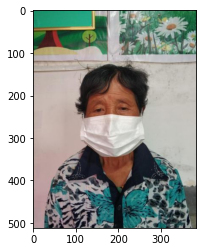

In [16]:

# meta 데이터와 이미지 경로를 불러옵니다.
test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

idx = 50
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = test_transform(image=image)['image'].to(device)
image = image.unsqueeze(0)
pred = model(image)
label = np.argmax(pred.detach().cpu().numpy())

masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}

feature_to_label = {}
features = [(m, g, a) for m in ['Mask', 'Incorrect', 'Normal'] for g in ['Male', 'Female'] for a in ["~ 30", "30 ~ 60", "60 ~"]]
for i, (m, g, a) in enumerate(features):
    feature_to_label[(m, g, a)] = i

label_to_feature = { feature_to_label[k]:k for k in feature_to_label}
m, g, a = label_to_feature[label]
print(m)
print(g)
print(a)
